# Applying Complex Orthogonal Decomposition to Lampreys swimming in fluid environment of various viscosity
# Part III - First mode - draft
## In this notebook, we look in detail at the first complex orthogonal mode
### Author: Yuexia Luna Lin (luna.lin@epfl.ch)
### Data provided by Prof. Eric Tytell.

# Start by loading some necessary libraries and our pre-processed dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import zipfile

import os
from os import listdir
from os.path import isfile, isdir, join
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.fft import rfft, irfft
from scipy.linalg import eigh
from scipy.optimize import curve_fit, brute, minimize

# The following two lines is to be able toeasily convert
# comma decimal place to point decimal place
import locale
#locale.setlocale(locale.LC_NUMERIC, "fr_CH.ISO8859-15")
import time

# To read Eric's h5 file, we can't use Pandas since it requires a particular structure within the HDF5 file.
# So we need this library
import h5py

# The following line is needed to render animation online (Google Colab)
#rc('animation', html='html5')
# THe following two lines are needed to upload and import files
# while working online (Google Colab)
#from google.colab import files
#import io

%matplotlib notebook

# We still need the functions from Part II to extract body position data, perform COD, etc. We copy and paste here, but these functions can be save as a separate module, to be imported like any python module

In [2]:
def extract_single_trial_bodyframe(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the frame where COM is at the origin, and the body axis align with x axis.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    # For each body part, average the bodycoordinate (this only works)
    # if we have projected to bodyframe and fixed the origin at COM
    xdata = np.array([df.loc[df['point'] == i, 'bodycoordx'].mean() for i in bodyparts])
    
    ydata = np.empty([num_frames, len(bodyparts)])
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'bodycoordy'].values
        
    return xdata, ydata

def extract_single_trial(df):
    """ This function extracts the y coordinates at each tracking point on the fish,
    in the frame where COM is at the origin, and the body axis align with x axis.""" 

    frames = df.loc[df["point"] == 1, 'frame'].unique()
    num_frames = len(frames)
    
    # Average the bodypart coordinate (along body axis) over time
    # First get unique body parts names
    bodyparts = df['point'].unique()
    num_parts = len(bodyparts)

    ydata = np.empty([num_frames, num_parts])
    xdata = np.empty_like(ydata)
    
    for fr in frames:
        start = fr*num_parts
        finish = (fr+1)*num_parts
        ydata[fr] = df.iloc[start:finish].loc[:,'mymm'].values
        xdata[fr] =  df.iloc[start:finish].loc[:,'mxmm'].values
    return xdata, ydata

# We pass in the real signals
# Organized as: each row represent the whole fish (N body parts) at a time point
def complex_orthog_decomp(real_signal, tf_type=None, dc_type=None):
    
    nf = real_signal.shape[0]
    zdata = np.empty_like(real_signal)
    
    if tf_type == None or tf_type == 'FFT':
        # Transform the time series at each sensor location into complex signal
        # See https://en.wikipedia.org/wiki/Analytic_signal
        
        ffty = np.fft.fft(real_signal, axis=0)
        freq = np.fft.fftfreq(nf)
        ffty[freq>0, :] = 2*ffty[freq>0, :]
        ffty[freq<0, :] = 0
        zdata = np.fft.ifft(ffty, axis=0)
        #print(zdata.shape)

    elif tf_type == 'H':

    # According to scipy documentation, hilbert transform output x_a(t) = x(t) + iy(t),
    # which is the complex signal COD calls for (Feeny, 2008)
    # We transform along column direction, axis=0, since each row represents a time point
        zdata = hilbert (real_signal, axis=0)
    
    else: 
        print("Transformation type can either be Fourier Transform (FFT) or Hilbert Transform (H).")
        print("Default is FFT.")
        
    # Cast the ndarray zdata to matrix for convenience
    # The complex ensemble matrix is organized as follows:
    # each row is a time series of signal at a given sensor.
    # In the fish example, in each row we have the time series of a body part
    Z = np.asmatrix(zdata).T

    # Assemble the complex correlation matrix
    R = 1./nf * (Z @ (Z.H))

    #print("Check complex correlation matrix is Hermitian norm(R-R.H): ", np.linalg.norm(R-R.H))
    
    num_samples = real_signal.shape[1]
    U = np.zeros([num_samples, num_samples])
    S = np.zeros(num_samples)
    Vh = np.empty_like(U)
    if dc_type == 'eig':
        # Compute the eigenvalues and eigenvectors of the correlation matrix
        # Using eigen decomposition
        S, U = np.linalg.eigh(R)
        S = np.flip(S)
        U = np.flip(U, axis=1)
        
    elif dc_type == None or dc_type == 'svd':
        # Since R is Hermitian (complex conjugate symmetric)
        # its SVD is just eigen decoposition
        U, S, Vh = np.linalg.svd(R)
        
    else: 
        print("Decomposition type can either be eigen 'eig' or SVD 'svd'.")
        print("Default is SVD.")

        
    return zdata, Z, R, S, U

# Use the real and imaginary part of the eigenmodes to compute traveling index
def traveling_index(vecs):
    # The number of traveling indices is the number of modes (columns in eigenvector matrix)
    tr_ind = np.zeros(vecs.shape[1])

    # For each mode, we create a rectangular matrix with columns being the real and imag part of the mode
    # The traveling index is the inverse of the condition number of this matrix
    for i in range(len(tr_ind)):
        tmp = np.concatenate( (np.real (vecs[:, i]).reshape(-1,1) , np.imag(vecs[:, i]).reshape(-1,1)), axis=1)
        cond = np.linalg.cond(tmp)
        tr_ind[i] = 1./cond
        
    return tr_ind

def low_band_filter(series, dt, thres):
    """ Threshold frequency included in the result"""
    fsignal = np.fft.fft(series)
    freq = np.fft.fftfreq(len(series), d = 0.02)
    fsignal[np.abs(freq)>thres] = 0
    return np.real(np.fft.ifft(fsignal))

def mid_band_filter(series, dt, thres_low, thres_high):
    """ Lower threshold included, while upper thershold excluded, in the result."""
    fsignal = np.fft.fft(series)
    freq = np.fft.fftfreq(len(series), d = 0.02)
    fsignal[np.abs(freq)<thres_low] = 0
    fsignal[np.abs(freq)>=thres_high] = 0
    print("Non zero frequncies:", np.sum(fsignal!=0))
    return np.real(np.fft.ifft(fsignal))


# Read in the pre-processed dataset

In [3]:
data_frame = pd.read_hdf("Data/processed_midline_all.h5")
dt = 0.02

In [4]:
data_frame.rename(columns = {'viscosity.cP': 'viscosity', 'len.mm': 'len'}, inplace=True)
data_frame["frame"] = data_frame["frame"].astype('int')

In [5]:
data_frame.head(30)

,filename,date,indiv,trial,t,frame,point,mxmm,mymm,viscosity,...,bodyaxisy,bodycoordx,bodycoordy,swimvelx,swimvely,swimvel,theta,d_theta,com_vel_theta,com_vel_d_theta
0,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,1.0,341.299771,88.110667,1.0,...,-0.311522,73.796770,-7.270154,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
1,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,2.0,349.324554,90.105424,1.0,...,-0.311522,65.549898,-6.665755,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
2,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,3.0,357.545449,91.064575,1.0,...,-0.311522,57.439287,-5.016190,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
3,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,4.0,365.759349,91.948042,1.0,...,-0.311522,49.358900,-3.296886,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
4,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,5.0,374.046024,91.781670,1.0,...,-0.311522,41.536407,-0.557311,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
5,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,6.0,382.245394,90.914370,1.0,...,-0.311522,34.015228,2.821113,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
6,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,7.0,390.329370,89.114436,1.0,...,-0.311522,26.894238,7.049815,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
7,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,8.0,398.584686,88.492048,1.0,...,-0.311522,19.243602,10.212945,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
8,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,9.0,406.743469,89.811668,1.0,...,-0.311522,11.079718,11.500629,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216
9,b'lamprey5-1-corr-midline.csv',15868,5,1,0.58,0,10.0,414.012944,93.737974,1.0,...,-0.311522,2.948849,10.034300,-206.905730,-68.994977,218.106139,-0.316794,0.148989,-0.321865,-0.842216


In [6]:
data_frame['indiv'].unique()

array([5, 6, 7, 8, 9])

In [7]:
data_frame['viscosity'].unique()

array([ 1., 10., 20.])

# First we look at the shapes of the modes, we pick a particular trial and visualze the top 3 modes

<IPython.core.display.Javascript object>


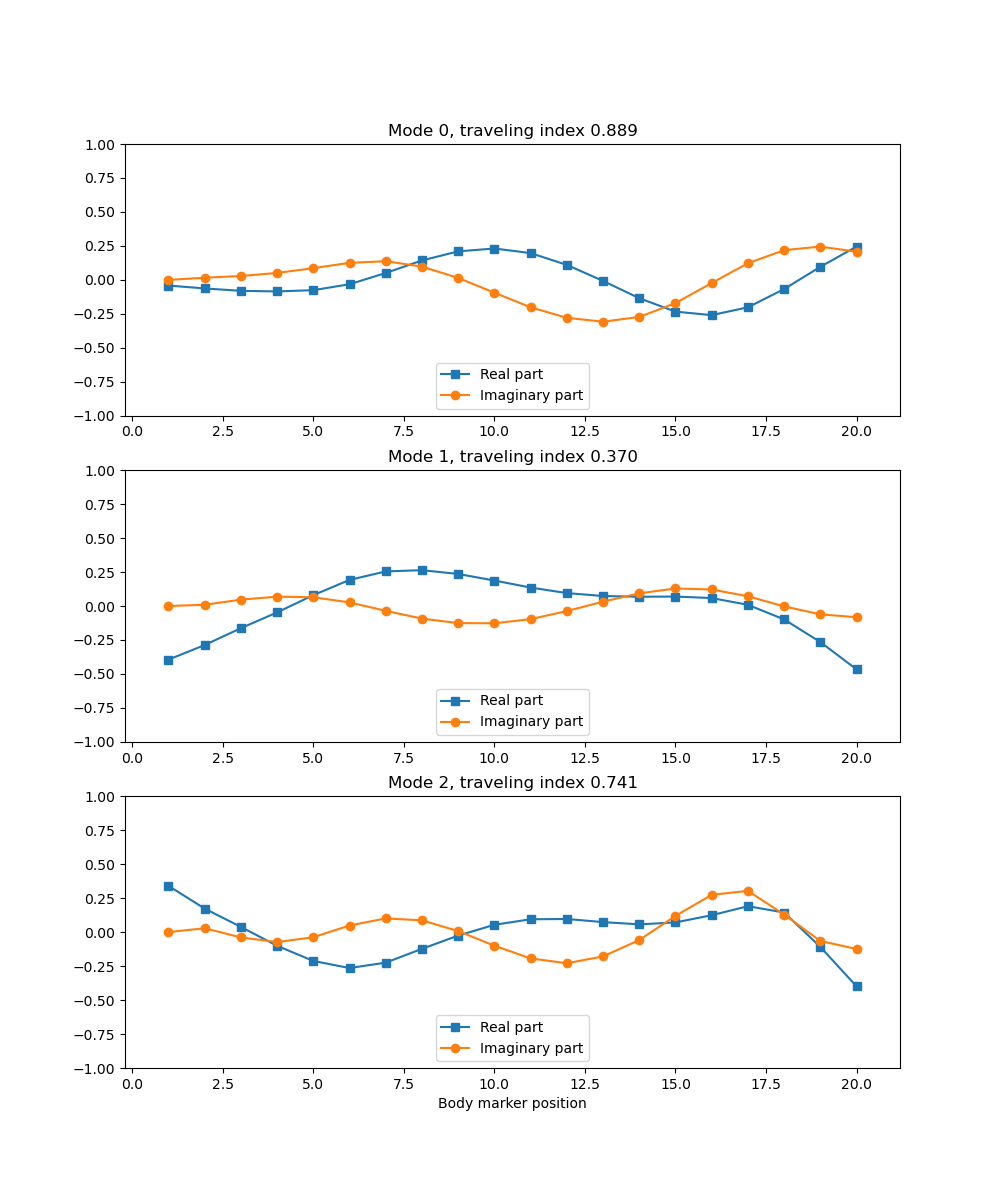

Text(0.5, 0, 'Body marker position')

In [8]:
# For this particular individual, we have shapes like these
# Then the question is, are the modes similar for all individuals? (Compare wave length, amplitude)
v = 20
ind = 8
tr = '29'

trial_df = data_frame.loc[(data_frame['viscosity'] == v) &\
                                      (data_frame['indiv'] == ind) &\
                                      (data_frame['trial'] == tr)].copy()
xdata, ydata = extract_single_trial_bodyframe(trial_df)
zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')
Q = U.H @ Z

# Plot the three modes' shapes
fig, ax = plt.subplots(3,1, figsize=(10, 12))
for i in range(3):
    mode = i
    
    ax[i].plot(range(1,21), np.real(U[:, mode]), marker='s', label='Real part')
    ax[i].plot(range(1,21), np.imag(U[:, mode]), marker='o', label='Imaginary part')
    ax[i].legend(loc='lower center')
    ax[i].set_xlim([-0.2,21.2])
    ax[i].set_ylim([-1,1])
    ax[i].set_title('Mode {}, traveling index {:.3f}'.format(mode, traveling_index(U)[mode]))
ax[-1].set_xlabel('Body marker position')

# plt.savefig('Mode_shapes_v{}_ind{}_trial{}.png'.format(v, ind, tr), format='png')

# Compute the Reynolds number of each swimming trial.
- Keep in mind that there are 3 viscosities
- Filter out the trials that have weird velocities

## Here we have also computed foreshortening, i.e. the ratio of head-tail distance in lab frame to the actual body length. But we didn't find any significant foreshortening using the 'len' field in the dataset, so I think the 'len' field is actually already the distance from head to tail computed from tracker positions.

## I used the assumption that the trackers are uniformly distributed, here I also check this assumption

In [9]:
rho = 997 # kg/m^3
mu_water = 0.001 # kg / (m s)
lengths = np.array( data_frame.loc[(data_frame['point']==1) & (data_frame['frame']==0),  'len'] ) / 1000 # convert from millimeter to meter

swimvels  = np.zeros_like(lengths, dtype=float)
mu = np.zeros_like(lengths, dtype =float)
good_data = np.ones_like(lengths, dtype=bool)
points = np.zeros(20, dtype=float)

co = 0
# fore_shortening_mean = np.zeros_like(lengths, dtype=float)
# fore_shortening_std = np.zeros_like(lengths, dtype=float)
for i in range(5,10):
    trials = data_frame[data_frame['indiv'] == i]['trial'].unique()
    for t in trials:
        ## This is to keep track of which data point has what viscosity
        mu[co] = data_frame.loc[(data_frame['indiv']==i) \
                            & (data_frame['point']==1) \
                            & (data_frame['trial']==t), 'viscosity'].unique()[0] * mu_water
        swimvel = np.array(data_frame.loc[(data_frame['indiv']==i) \
                                    & (data_frame['point']==1) \
                                    & (data_frame['trial']==t), 'swimvel'])
       
        swimvels[co] = np.mean(swimvel) / 1000 # convert from millimeter to meter

        vel_max = data_frame.loc[(data_frame['indiv']==i) \
                                    & (data_frame['point']==1) \
                                    & (data_frame['trial']==t), 'swimvelx'].max()
        if(np.abs(vel_max) > 500):
            print(f'index {co}, individual {i}, trial {t}, visc {mu[co]}, swimvelx max {vel_max}')
            print(f'Abnormal data, abandon!')
            good_data[co]=False
            
        ## Here we compute the foreshortening, i.e. the shortening of the labframe anterior-posterior distance
        ## Though it seems the "len" field is computed from this information, rather than the actual length
        ## So the foreshortening computed from this data is apprximately 1 :/
#         dx = np.array(data_frame.loc[(data_frame['indiv']==i) \
#                                     & (data_frame['point']==20) \
#                                     & (data_frame['trial']==t), 'bodycoordx']) - \
#             np.array(data_frame.loc[(data_frame['indiv']==i) \
#                                     & (data_frame['point']==1) \
#                                     & (data_frame['trial']==t), 'bodycoordx'])
#         dy = np.array(data_frame.loc[(data_frame['indiv']==i) \
#                                     & (data_frame['point']==20) \
#                                     & (data_frame['trial']==t), 'bodycoordy']) - \
#             np.array(data_frame.loc[(data_frame['indiv']==i) \
#                                     & (data_frame['point']==1) \
#                                     & (data_frame['trial']==t), 'bodycoordy'])
#         L = np.sqrt(dx**2 + dy**2)
       
#         fs = L/data_frame.loc[(data_frame['indiv']==i) \
#                                     & (data_frame['point']==1) \
#                                     & (data_frame['trial']==t) \
#                                     & (data_frame['point']==1), 'len'].unique()[0]
       
#         fore_shortening_mean[co] = np.mean(fs)
#         fore_shortening_std[co] = np.std(fs)                            
#         print(fore_shortening_mean[co])
        


        ## Here we also calculate tracker position on the animal body to see if they are uniformly distributed
        pts = np.array(data_frame.loc[(data_frame['indiv']==i) \
                                    & (data_frame['trial']==t), 'bodycoordx']).reshape(-1, 20).T

        pt_ones = np.array(data_frame.loc[(data_frame['indiv']==i) \
                                    & (data_frame['point']==1) \
                                    & (data_frame['trial']==t), 'bodycoordx'])
        
        pts = (pts - pt_ones) / data_frame.loc[(data_frame['indiv']==i) \
                                    & (data_frame['point']==1) \
                                    & (data_frame['trial']==t) \
                                    & (data_frame['point']==1), 'len'].unique()[0]
        points += np.mean(pts, axis=1)
        
        co+=1
    
re = rho* swimvels * lengths/mu
points = points/co

print(f'Average Reynolds number:\n'
      f'1x water: {np.mean(re[ (mu == 0.001 ) & (good_data==True)]):.0f} +/- {np.std(re[ (mu == 0.001 ) & (good_data==True)]):.1f}\n'
      f'2x water: {np.mean(re[ (mu == 0.002 ) & (good_data==True)]):.0f} +/- {np.std(re[ (mu == 0.002 ) & (good_data==True)]):.1f}\n'
      f'3x water: {np.mean(re[ (mu == 0.003 ) & (good_data==True)]):.0f} +/- {np.std(re[ (mu == 0.003 ) & (good_data==True)]):.1f}')


index 137, individual 8, trial 1, visc 0.001, swimvelx max -762.0809528075866
Abnormal data, abandon!
Average Reynolds number:
1x water: 29628 +/- 8460.6
2x water: nan +/- nan
3x water: nan +/- nan


/Users/etytel01/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/etytel01/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/etytel01/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/etytel01/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/etytel01/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# We focus on the first mode: forward locomotion.
# We plot the following for the longest trial in each viscosity
- complex orthogonal mode shape (COM) (spatial mode) in the complex plane
- complex orthogonal coordinates (COC) (time coefficients) in the complex plane
- the Fourier transform of the COC, with maximum amplitude frequency in the legend

## Each column in the figure below is one trial.

<IPython.core.display.Javascript object>


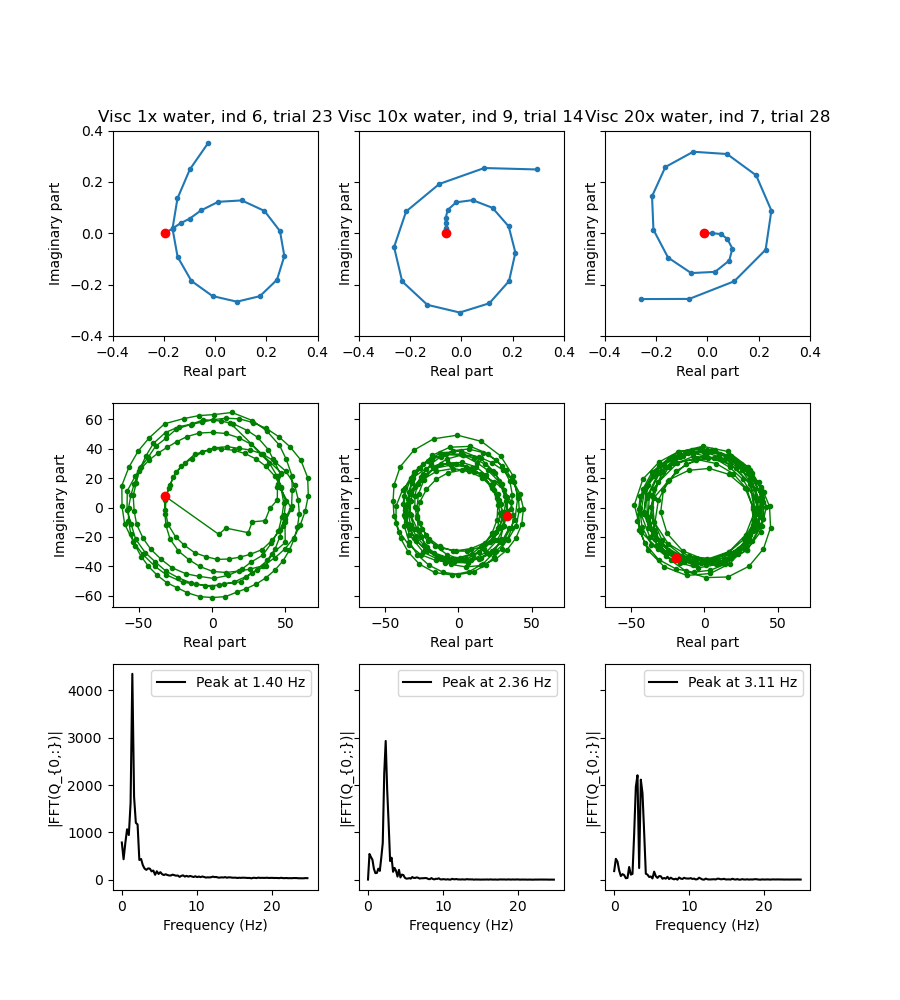

Viscosity 1x water:  lowest detectable frequency is 0.23
Viscosity 10x water:  lowest detectable frequency is 0.20
Viscosity 20x water:  lowest detectable frequency is 0.22


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_7789/1357534899.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vels = trial_df.loc[trial_df['point']==1, {'swimvelx', 'swimvely'}].copy()
/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_7789/1357534899.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  bodyaxis = trial_df.loc[trial_df['point']==1, {'bodyaxisx', 'bodyaxisy'}].copy()
/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_7789/1357534899.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  vels = trial_df.loc[trial_df['point']==1, {'swimvelx', 'swimvely'}].copy()
/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_7789/1357534899.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use

In [10]:
trios = [[1, 6, '23'],[10, 9, '14'],[20, 7, '28']]
fig,ax = plt.subplots(3,3,figsize=(9,10),sharey='row',sharex='row')
mode = 0


for i in range(3):
    v = trios[i][0]
    ind = trios[i][1]
    tr = trios[i][2]
    
    trial_df = data_frame.loc[(data_frame['viscosity'] == v) &\
                                          (data_frame['indiv'] == ind) &\
                                          (data_frame['trial'] == tr)]
    
    xdata, ydata = extract_single_trial_bodyframe(trial_df)
    zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')
    Q = U.H @ Z

    num_frames = trial_df['frame'].max()+1
    time = np.arange(num_frames)*dt
    vels = trial_df.loc[trial_df['point']==1, {'swimvelx', 'swimvely'}].copy()
    swimvelx = vels['swimvelx']
    swimvely = vels['swimvely']
    speed = np.sqrt(swimvelx**2 + swimvely**2)
    bodyaxis = trial_df.loc[trial_df['point']==1, {'bodyaxisx', 'bodyaxisy'}].copy()
    bodyx = bodyaxis['bodyaxisx']
    bodyy = bodyaxis['bodyaxisy']

    vels_moving_avg = vels.rolling(10, center=True).mean()
    swimvelx_ma = np.array(vels_moving_avg['swimvelx'])
    swimvely_ma = np.array(vels_moving_avg['swimvely'])
    speed_ma =  np.sqrt(swimvelx_ma**2 + swimvely_ma**2, dtype=float)

    #plt.plot(time, speed_ma)
    costheta = (swimvelx * bodyx  + swimvely * bodyy) / speed

#     ax[i].plot(time, trial_df.loc[trial_df['point']==1, 'theta'], label='Bodyaxis theta')
#     ax[i].plot(time, trial_df.loc[trial_df['point']==1, 'com_vel_theta'], label='COM vel theta')
#     # ax[0].plot(time, np.arccos(costheta), 'b-')
#     ax[i].legend()

#     ax[i].plot(np.real(Q[mode].reshape(-1,1)),np.imag(Q[mode].reshape(-1,1)), '-')
    ax[0,i].plot(np.real(U[:, mode]),np.imag(U[:, mode]), '.-')
    ax[0,i].plot(np.real(U[0, mode]),np.imag(U[0, mode]), 'ro')
    ax[0,i].set_xlim([-0.4, 0.4])
    ax[0,i].set_ylim([-0.4, 0.4])
    ax[0,i].set_title(f'Visc {v}x water, ind {ind}, trial {tr}')
    ax[0,i].set_xlabel("Real part")
    ax[0,i].set_ylabel("Imaginary part")
    ax[0,i].set_aspect(1)
    
    ax[1,i].plot(np.real(Q[mode]).reshape(-1,1) ,np.imag(Q[mode]).reshape(-1,1), 'g.-', linewidth=1)
    ax[1,i].plot(np.real(Q[mode,0]),np.imag(Q[mode,0]), 'ro')
    ax[1,i].set_xlabel("Real part")
    ax[1,i].set_ylabel("Imaginary part")
    ax[1,i].set_aspect(1)
    
    fft_res = np.fft.fft(np.array( np.real(Q[mode]).reshape(-1,1)).flatten())
    freq = np.fft.fftfreq(Q.shape[1], d = 0.02)
    peak_freq = freq[np.argmax(np.abs(fft_res[freq>=0]))]
    print(f'Viscosity {v}x water:  lowest detectable frequency is {1/Q.shape[1]/0.02:.2f}')
    ax[2,i].plot(freq[freq>=0], np.abs(fft_res)[freq>=0], 'k-', label=f'Peak at {peak_freq:.2f} Hz')
    ax[2,i].legend(loc='best')
    ax[2,i].set_xlabel('Frequency (Hz)')
    ax[2,i].set_ylabel('|FFT(Q_{0,:})|')
    
## Uncomment below to save the figure
# fig.savefig("mode1_shapes_fft.png", format='png')

# Above we visualize 1 trial per viscosity. Now we batch process all trials. We look at in the first mode:
- Winding numbers (how many time COM wrap around itself on the complex plane)
- Wavelengths (bodylength / winding number)
- Dominant wave frequency (frequency with the largest Fourier amplitude); for this we filter out the very low and the very high frequencies.

## Note that in this dataset, winding number is never smaller than 1. If that's the case, additional care is required in calcuation wave length. A simple fix is to linearly extrapolate beyond the body length. (This is the case in the injured lamprey dataset.)

In [21]:
mode = 0
winding_numbers = [[],[],[]]
wavelengths = [[],[],[]]
peak_freqs = [[],[],[]]
individuals = [[],[],[]]
trials = [[],[],[]]
viscosities = [[],[],[]]
speeds = [[],[], []]
modesreal = [[], [], []]
modesimag = [[], [], []]
traveling_indices = [[], [], []]

viscosityind = {1: 0, 10: 1, 20: 2}

for ind in range(5,10):
    trials1 = data_frame[data_frame['indiv'] == ind]['trial'].unique()
    for tr in trials1:
    
        trial_df = data_frame.loc[(data_frame['indiv'] == ind) &\
                             (data_frame['trial'] == tr)]
        v=viscosityind[trial_df['viscosity'].unique()[0]]
        nf = trial_df['frame'].max() + 1
        
        # Only accept data from long trials, >= 2 seconds
        if nf < 50: continue
    
        print(f'Working on individual {ind} trial {tr}.')
        xdata, ydata = extract_single_trial_bodyframe(trial_df)
        zdata, Z, R, S, U = complex_orthog_decomp(ydata, tf_type = 'H', dc_type = 'svd')
        first_mode = U[:, mode]
        shifted_real = np.array(np.real(first_mode) - np.mean(np.real(first_mode))).flatten()
        shifted_imag = np.array(np.imag(first_mode) - np.mean(np.imag(first_mode))).flatten()
#         print( np.mean(np.real(first_mode)), np.sum(np.real(first_mode)) )

        modesreal[v].append(np.real(U[:,:3]))
        modesimag[v].append(np.imag(U[:,:3]))
        
        tot_angle = 0
        exceed_2pi = False
        wavelength_frac = -1
        
        # this is how we compute winding number
        # Integrate the angles, and divide by 2PI
        for l in range(1,len(first_mode)):
            last_vector = np.array([shifted_real[l-1], shifted_imag[l-1]])
            this_vector = np.array([shifted_real[l], shifted_imag[l]])
            #print(last_vector, this_vector)
            last_tot = tot_angle
            tot_angle += np.arccos( np.dot(last_vector, this_vector)\
                                   / np.linalg.norm(last_vector)/np.linalg.norm(this_vector) )
            # We keep track at which point winding number becomes 1, by linearly interpolating
            # between the points before and after winding number = 1
            if not exceed_2pi and tot_angle>= np.pi * 2:
                wavelength_frac = l-1 + (np.pi * 2 - last_tot)/ (tot_angle - last_tot)
                exceed_2pi = True
                
        winding_number = tot_angle / 2/np.pi
        winding_numbers[v].append(winding_number)
        
        # Here we calcuate the wavelength of the body deformation
        # Assuming the trackers are spaced uniformly on the lamprey body
        # Point 1 is at the head, and point 20 is at the tail, which divide the body into 19 equal segments
        wavelength = trial_df['len'].unique()[0] / 19.0 * wavelength_frac
        wavelengths[v].append(wavelength)
        
        # Get the traveling wave index
        traveling_indices[v].append(traveling_index(U)[:3])

        Q = U.T @ Z
        fft_res = np.fft.fft(np.array( np.real(Q[mode]).reshape(-1,1)).flatten())
        freq = np.fft.fftfreq(Q.shape[1], d = 0.02)
        freq_thres = 1
        positive_freq = freq[freq>freq_thres]
        peak_freq = positive_freq[np.argmax(np.abs(fft_res[freq>freq_thres]))]
        peak_freqs[v].append(peak_freq)
        
        individuals[v].append(ind)
        trials[v].append(tr)
        viscosities[v].append(trial_df['viscosity'].unique()[0])
        
        # If the peak frequency is largest than 10, then there's something very strange about the dataset
        # we visualize it to see what's going on
        if(peak_freq > 10.):
            fig = plt.figure()
#             plt.plot(freq, np.abs(fft_res), 'k-')
#             plt.plot(np.real(Q[mode]).reshape(-1,1) ,np.imag(Q[mode]).reshape(-1,1), 'g.-', linewidth=1)
            plt.plot(np.arange(Q.shape[1])*0.02, np.array( np.real(Q[mode]).reshape(-1,1)).flatten())
            break
        #print(f'Viscosity {v} winding angle is {winding_number}.')
        
        speed = np.array(trial_df.loc[trial_df['point']==1, 'swimvel'])
        speeds[v].append(np.mean(speed))

Working on individual 5 trial 1.
Working on individual 5 trial 10.
Working on individual 5 trial 11.
Working on individual 5 trial 14.
Working on individual 5 trial 15.
Working on individual 5 trial 16.
Working on individual 5 trial 17.
Working on individual 5 trial 18.
Working on individual 5 trial 19.
Working on individual 5 trial 2.
Working on individual 5 trial 20.
Working on individual 5 trial 21.
Working on individual 5 trial 22.
Working on individual 5 trial 23.
Working on individual 5 trial 24.
Working on individual 5 trial 25.
Working on individual 5 trial 3.
Working on individual 5 trial 4.
Working on individual 5 trial 6.
Working on individual 5 trial 8.
Working on individual 5 trial 9.
Working on individual 5 trial 28.
Working on individual 5 trial 29.
Working on individual 5 trial 30.
Working on individual 5 trial 31.
Working on individual 5 trial 31a.
Working on individual 5 trial 32.
Working on individual 5 trial 32a.
Working on individual 5 trial 33.
Working on individu

Build up a new pandas DataFrame with the COD results

In [12]:
index = pd.MultiIndex.from_product([range(1,213), range(1,21), range(1,4)], names=['ind','point','mode'])

In [22]:
traveling_indices[0]

[array([0.72953862, 0.64691835, 0.98825787]),
 array([0.73713386, 0.77103713, 0.66031255]),
 array([0.7701137 , 0.51756747, 0.88801695]),
 array([0.79596006, 0.54279215, 0.88402308]),
 array([0.72830393, 0.57957602, 0.58030543]),
 array([0.76318812, 0.78749535, 0.61620287]),
 array([0.74877417, 0.35793724, 0.55812709]),
 array([0.76528094, 0.74059549, 0.58183135]),
 array([0.76248391, 0.45569508, 0.73495304]),
 array([0.72262878, 0.47780696, 0.86240732]),
 array([0.75755392, 0.61428704, 0.84577758]),
 array([0.7592511 , 0.44414066, 0.71446577]),
 array([0.66338574, 0.74594187, 0.47527742]),
 array([0.7386649 , 0.74043367, 0.61698723]),
 array([0.7407268 , 0.81379002, 0.44939164]),
 array([0.73781928, 0.71764671, 0.67897265]),
 array([0.78888679, 0.47816266, 0.62779154]),
 array([0.74034055, 0.81589022, 0.84036386]),
 array([0.78780126, 0.62186331, 0.59599175]),
 array([0.83569909, 0.46110699, 0.63672904]),
 array([0.71990742, 0.82880862, 0.44785591]),
 array([0.79349506, 0.52373439, 0.

In [23]:
trialvalues = [individuals, trials, viscosities, speeds, peak_freqs, wavelengths, winding_numbers]
colnames = ['indiv', 'trial', 'viscosity', 'speed', 'peakfreq', 'wavelength', 'windingnum']

cols = {}
for c, n in zip(trialvalues, colnames):
    v = np.tile(np.array(np.concatenate(c))[:,np.newaxis,np.newaxis], (1, 20, 3))
    cols.update({n: pd.Series(v.flatten(), index=index)})

coddata = pd.DataFrame(cols)

In [30]:
traveling = np.concatenate(traveling_indices)
traveling = np.tile(traveling[:, np.newaxis, :], (1, 20, 1))

coddata['traveling'] = pd.Series(traveling.flatten(), index=index)

In [31]:
coddata['modereal'] = pd.Series(np.concatenate(modesreal).flatten(), index=index)
coddata['modeimag'] = pd.Series(np.concatenate(modesimag).flatten(), index=index)

Check that the COD modes are distributed in the Pandas array the way we think they are.

This should be the first trial, mode 1, real part

In [32]:
np.all(coddata.loc[(1,slice(None),1), "modereal"].to_numpy() == \
    np.array(modesreal[0][0])[:,0])

True

This should be the first trial in the middle viscosity, second mode, imaginary part

In [33]:
len(modesreal[0])

88

In [34]:
np.all(coddata.loc[(89,slice(None),2), "modeimag"].to_numpy() == np.array(modesimag[1][0])[:,1])

True

In [35]:
coddata.reset_index().head()

,ind,point,mode,indiv,trial,viscosity,speed,peakfreq,wavelength,windingnum,traveling,modereal,modeimag
0,1,1,1,5,1,1.0,216.631547,1.25,119.208499,1.243395,0.729539,-0.119871,-1.686143e-17
1,1,1,2,5,1,1.0,216.631547,1.25,119.208499,1.243395,0.646918,-0.337206,0.000000e+00
2,1,1,3,5,1,1.0,216.631547,1.25,119.208499,1.243395,0.988258,0.381277,-1.163439e-15
3,1,2,1,5,1,1.0,216.631547,1.25,119.208499,1.243395,0.729539,-0.116021,7.479587e-03
4,1,2,2,5,1,1.0,216.631547,1.25,119.208499,1.243395,0.646918,-0.247065,2.193864e-02


In [36]:
coddata.reset_index().to_csv('Data/coddata.csv', mode='w')

In [15]:
# Compute mean, std in winding number, peak frequency, and swimming speed
# Compute wave speed = wavelength * frequency
# Compute the ratio between swimming speed and wave speed
wind_num_means = np.array([np.mean(winding_numbers[i]) for i in range(3)])
wind_num_stds = np.array([np.std(winding_numbers[i]) for i in range(3)])

wl_means = np.array([np.mean(wavelengths[i]) for i in range(3)])
wl_stds = np.array([np.std(wavelengths[i]) for i in range(3)])

pf_means = np.array([np.mean(peak_freqs[i]) for i in range(3)])
pf_stds = np.array([np.std(peak_freqs[i]) for i in range(3)])

wavespeeds = np.array([ np.array(wavelengths[i]) * np.array(peak_freqs[i])  for i in range(3) ])
ws_means = np.array([np.mean(wavespeeds[i]) for i in range(3)])
ws_stds = np.array([np.std(wavespeeds[i]) for i in range(3)])

speed_means = np.array([np.mean( speeds[i]) for i in range(3)])
speed_stds = np.array([np.std(speeds[i]) for i in range(3)])

speed_ratios = np.array([speeds[i]/wavespeeds[i] for i in range(3)])
sr_means = np.array([np.mean(speed_ratios[i]) for i in range(3)])
sr_stds = np.array([np.std(speed_ratios[i]) for i in range(3)])

/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_10414/3616707083.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  wavespeeds = np.array([ np.array(wavelengths[i]) * np.array(peak_freqs[i])  for i in range(3) ])
/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_10414/3616707083.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  speed_ratios = np.array([speeds[i]/wavespeeds[i] for i in range(3)])


# A bunch of visualizations, data points are scattered, mean and 1 standard deviation are plotted as black symbol and error bars
- Swimming speed
- Winding numbers
- Wavelenghths
- Peak frequencies
- Wave speeds
- Speed ratios

## Uncomment the plt.savefig(...) command to save the figure to file

<IPython.core.display.Javascript object>


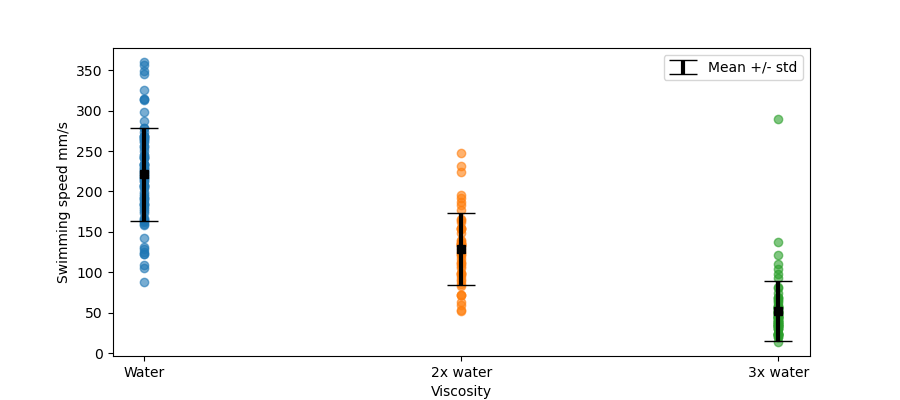

In [16]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(speeds[0]), speeds[0], alpha=0.6)
plt.scatter(np.ones_like(speeds[1]), speeds[1], alpha=0.6)
plt.scatter(np.ones_like(speeds[2])*2, speeds[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(speed_means), yerr=speed_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), speed_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Swimming speed mm/s")
plt.legend(loc='best')
# plt.savefig('Figures/speeds.png', format='png')

<IPython.core.display.Javascript object>


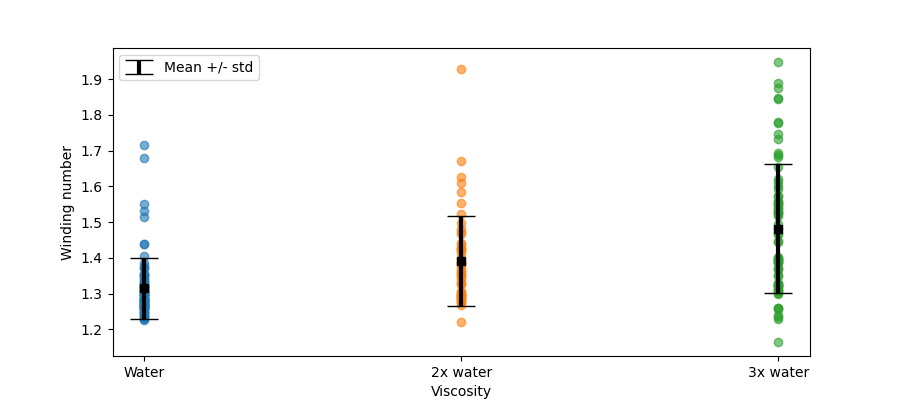

In [17]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(winding_numbers[0]), winding_numbers[0], alpha=0.6)
plt.scatter(np.ones_like(winding_numbers[1]), winding_numbers[1], alpha=0.6)
plt.scatter(np.ones_like(winding_numbers[2])*2, winding_numbers[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(wind_num_means), yerr=wind_num_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), wind_num_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Winding number")
plt.legend(loc='best')
# plt.savefig('Figures/winding_numbers.png', format='png')

<IPython.core.display.Javascript object>


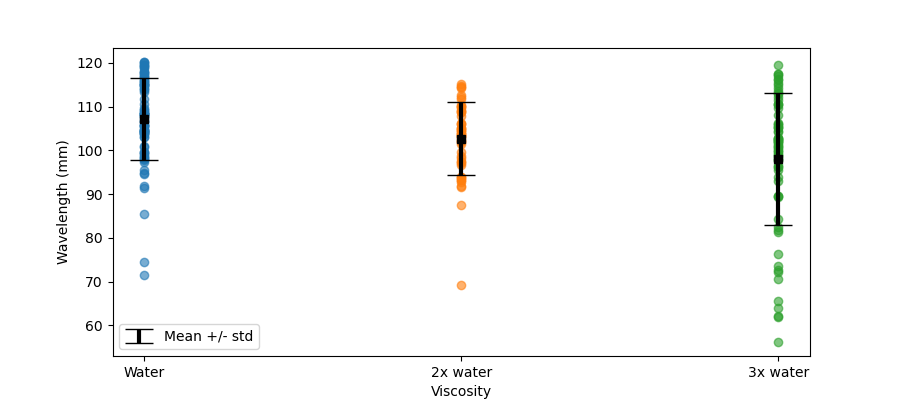

In [18]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(wavelengths[0]), wavelengths[0], alpha=0.6)
plt.scatter(np.ones_like(wavelengths[1]), wavelengths[1], alpha=0.6)
plt.scatter(np.ones_like(wavelengths[2])*2, wavelengths[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(wl_means), yerr=wl_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), wl_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Wavelength (mm)")
plt.legend(loc='best')
# plt.savefig('Figures/wavelengths.png', format='png')

<IPython.core.display.Javascript object>


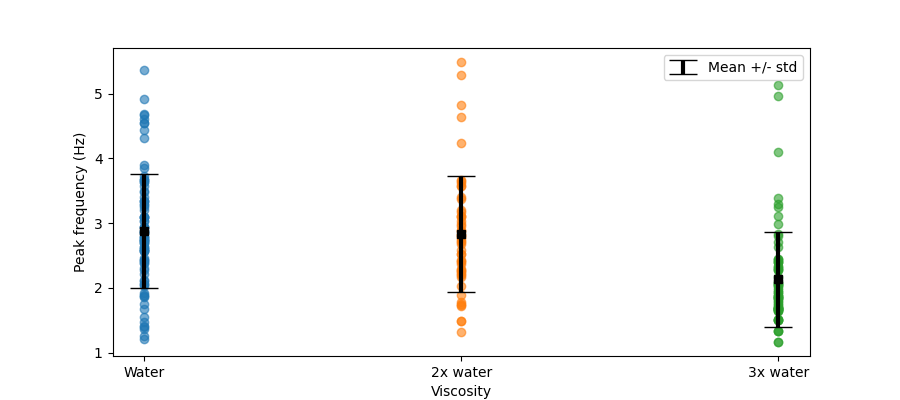

In [19]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(peak_freqs[0]), peak_freqs[0], alpha=0.6)
plt.scatter(np.ones_like(peak_freqs[1]), peak_freqs[1], alpha=0.6)
plt.scatter(np.ones_like(peak_freqs[2])*2, peak_freqs[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(pf_means), yerr=pf_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), pf_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Peak frequency (Hz)")
plt.legend(loc='best')
# plt.savefig('Figures/peak_freqs.png', format='png')

<IPython.core.display.Javascript object>


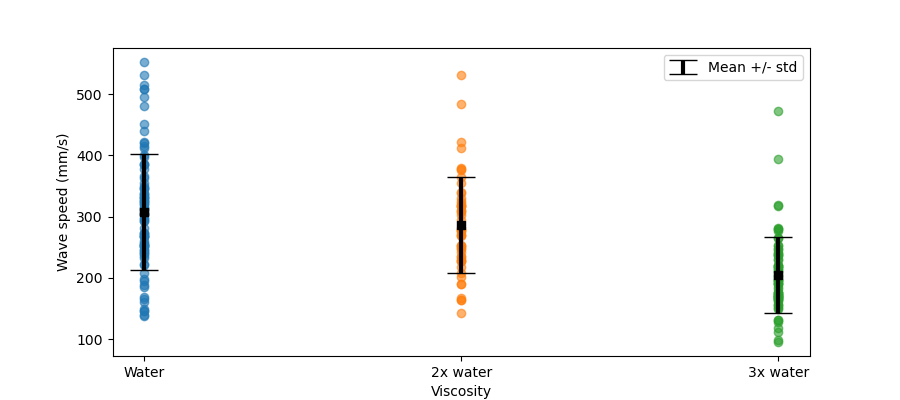

In [20]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(wavespeeds[0]), wavespeeds[0], alpha=0.6)
plt.scatter(np.ones_like(wavespeeds[1]), wavespeeds[1], alpha=0.6)
plt.scatter(np.ones_like(wavespeeds[2])*2, wavespeeds[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(ws_means), yerr=ws_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), ws_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Wave speed (mm/s)")
plt.legend(loc='best')
# plt.savefig('Figures/wavespeeds.png', format='png')

<IPython.core.display.Javascript object>


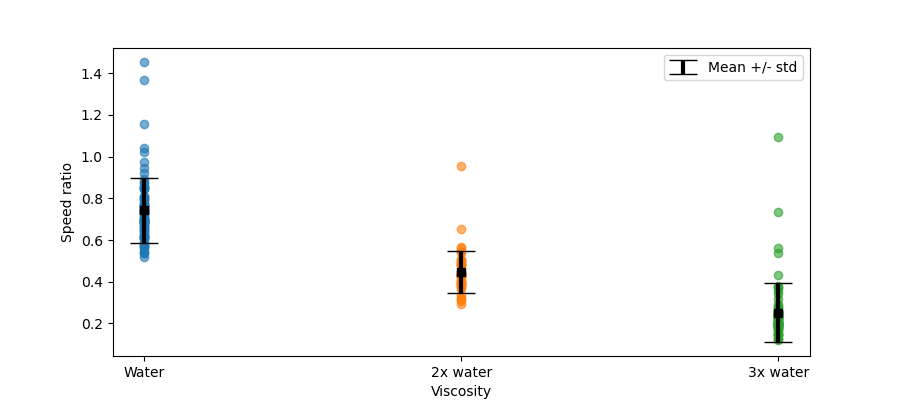

In [21]:
fig = plt.figure(figsize=(9,4))
plt.scatter(np.zeros_like(speed_ratios[0]), speed_ratios[0], alpha=0.6)
plt.scatter(np.ones_like(speed_ratios[1]), speed_ratios[1], alpha=0.6)
plt.scatter(np.ones_like(speed_ratios[2])*2, speed_ratios[2], alpha=0.6)
plt.errorbar(np.arange(3), np.array(sr_means), yerr=sr_stds, \
             capsize=10, ecolor='k', elinewidth=3, linestyle='', label="Mean +/- std")
plt.plot(np.arange(3), sr_means, 'ks')

plt.xlabel("Viscosity")
plt.xticks(np.arange(3), label=["Water", "2x water", "3x water"])
ax = plt.gca()
ax.set_xticklabels(["Water", "2x water", "3x water"])
plt.ylabel("Speed ratio")
plt.legend(loc='best')
# plt.savefig('Figures/speed_ratios.png', format='png')